In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy

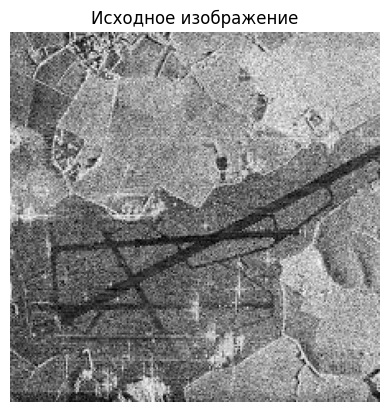

In [74]:
# Загрука изображения
image_path = 'sar_3.jpg'
image = cv2.imread(image_path)

if image is None:
    raise FileNotFoundError(f"Изображение {image_path} не найдено!")

image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')
plt.title('Исходное изображение')
plt.axis('off')
plt.show()

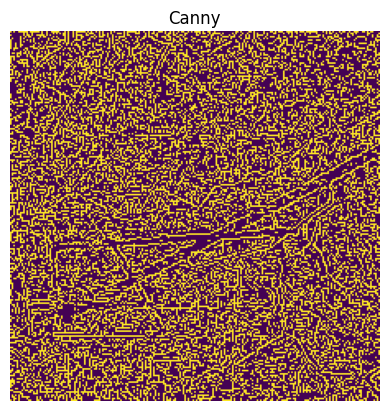

In [114]:
line_image = image.copy()
canny = cv2.Canny(image_gray,100,150)
plt.imshow(canny)
plt.title('Canny')
plt.axis('off')
plt.show()

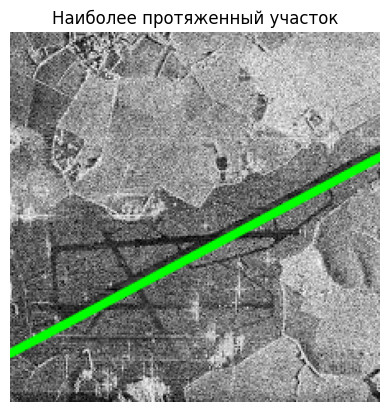

In [115]:
lines = cv2.HoughLines(canny, 1, np.pi / 180, 140)

max_line = None
max_len = 0

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        len_lim = 1000
        pt1 = (int(x0 + len_lim*(-b)), int(y0 + len_lim*(a)))
        pt2 = (int(x0 - len_lim*(-b)), int(y0 - len_lim*(a)))

        length = np.sqrt((pt2[0] - pt1[0])**2 + (pt2[1] - pt1[1])**2)

        if length > max_len:
            max_len = length
            max_line = (pt1, pt2, rho, theta)

if max_line is not None:
    pt1, pt2, rho, theta = max_line
    cv2.line(line_image, max_line[0], max_line[1], (0,255,0), 3, cv2.LINE_AA)

plt.imshow(line_image, cmap='gray')
plt.title('Наиболее протяженный участок')
plt.axis('off')
plt.show()

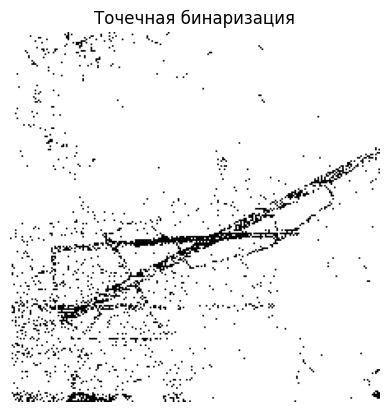

In [117]:
#Точечная бинаризация
bin_img = copy.deepcopy(image_gray)
T  = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

plt.imshow(bin_img, cmap='gray')
plt.title('Точечная бинаризация')
plt.axis('off')
plt.show()

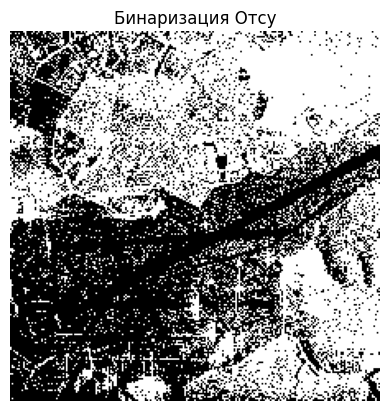

In [ ]:
# otsu binarization
_,th2 = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

plt.imshow(th2, cmap='gray')
plt.title('Бинаризация Отсу')
plt.axis('off')
plt.show()

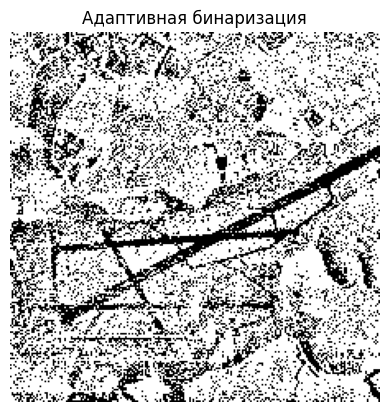

In [120]:
# Адаптивная бинаризация
th3 = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,71,21)

plt.imshow(th3, cmap='gray')
plt.title('Адаптивная бинаризация')
plt.axis('off')
plt.show()

In [127]:
# Оператор Собеля
scale = 1
delta = 0
ddepth = cv2.CV_16S
grad_x = cv2.Sobel(image_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(image_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad = cv2.addWeighted(grad_x, 0.5, grad_y, 0.5,0.0)

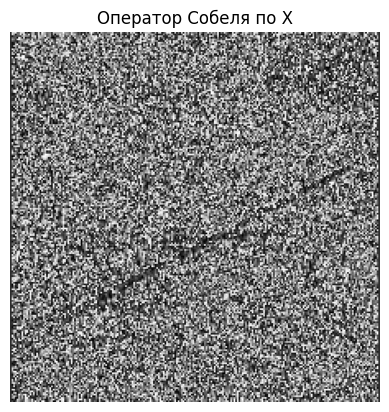

In [128]:
# По Х
plt.imshow((grad_x - grad_x.min())*255, cmap='gray')
plt.title('Оператор Собеля по Х')
plt.axis('off')
plt.show()

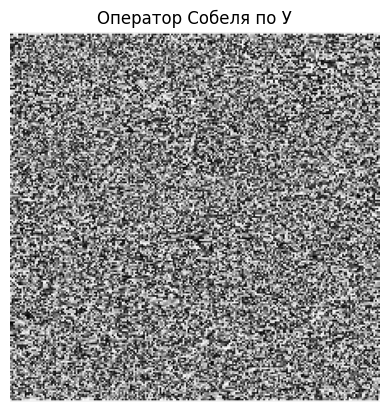

In [129]:
# По У
plt.imshow((grad_y - grad_y.min())*255, cmap='gray')
plt.title('Оператор Собеля по У')
plt.axis('off')
plt.show()

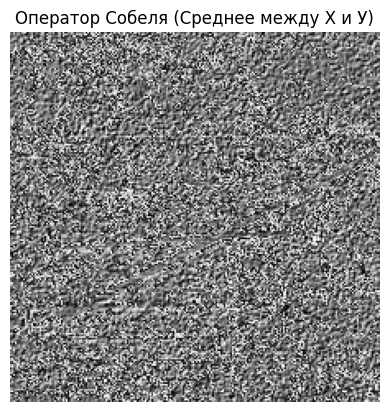

In [130]:
# Среднее между Х и У
th3 = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,71,21)

plt.imshow((grad - grad.min())*255, cmap='gray')
plt.title('Оператор Собеля (Среднее между Х и У)')
plt.axis('off')
plt.show()

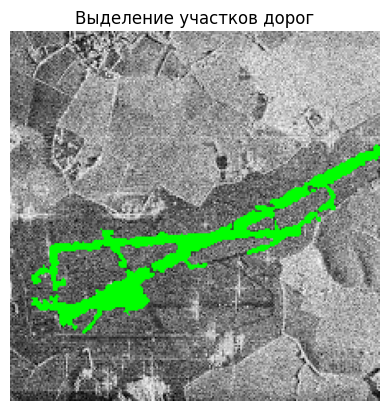

In [141]:
#Выделение дороги
blur = cv2.GaussianBlur(bin_img, (5, 5), 0)
thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 55, 2)
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_line_road = image.copy()

road_mask = np.zeros_like(image_gray)
image_with_roads = image.copy()

if contours:
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > 500:
            cv2.drawContours(image_line_road, [contour], -1, (255, 0, 0), 1)
            cv2.fillPoly(road_mask, [contour], 255)
            cv2.fillPoly(image_with_roads, [contour], (0, 255, 0))

road = cv2.bitwise_and(image, image,mask=road_mask)

plt.imshow(image_with_roads, cmap='gray')
plt.title('Выделение участков дорог')
plt.axis('off')
plt.show()
